# Toy topology and signals dataset

In [2]:
import numpy as np 
from itertools import combinations
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.linear_model import OrthogonalMatchingPursuit

In [2]:
# Let's generate a toy topology for our example

nodes = [i for i in range(7)]
edges = [
    (0,1),
    (0,3),
    (0,6),
    (1,2),
    (1,5),
    (2,4),
    (4,6),
    (5,6)
]

V = 7
E = len(edges)

d = 10                                         # Node and edges stalks dimension

F = {
    e:{
        e[0]:np.random.randn(d,d),
        e[1]:np.random.randn(d,d)
        } 
        for e in edges
    }                                           # Incidency linear maps

# Sheaf representation 

# Coboundary map

B = np.zeros((d*E, d*V))

for i in range(len(edges)):
    edge = edges[i]

    u = edge[0] 
    v = edge[1] 

    B_u = F[edge][u]
    B_v = F[edge][v]

    B[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
    B[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

# Sheaf Laplacian

L_f = B.T @ B

In [3]:
N = 100
X = np.random.randn(V*d,N)

In [4]:
Lambda, U = np.linalg.eig(L_f)
H = 1/(1 + 10*Lambda)

In [5]:
Y = U @ np.diag(H) @ U.T @ X

#Y += np.random.normal(0, 10e-2, size=Y.shape)

In [6]:
Y_ = Y.reshape((V, d, N)).transpose(1, 0, 2).reshape(d, V * N)

In [7]:
Y_.shape

(10, 700)

In [59]:
Y

array([[ 0.01614714,  0.06827788,  0.01989991, ...,  0.07556531,
         0.03884675, -0.02810642],
       [ 0.09961387, -0.10992272, -0.11755716, ..., -0.04937176,
        -0.01101056, -0.17309353],
       [ 0.04200499, -0.00391957,  0.04448012, ...,  0.03806193,
         0.12546436, -0.09727891],
       ...,
       [ 0.05511063, -0.0166209 ,  0.00614227, ...,  0.04632259,
         0.13876607, -0.08942779],
       [-0.02895585,  0.01767017, -0.01227345, ...,  0.01159964,
        -0.05405894,  0.05881236],
       [ 0.05368272,  0.02387523, -0.06289261, ..., -0.00156949,
         0.08385374, -0.08486124]])

# Imposed dictionary for learned sparsity

In [60]:
# Subroutines for subproblems

def grad(Y, D, X): 
    return - Y @ X.T + D @ X @ X.T

def proj(D):

    return np.apply_along_axis(lambda d: d/np.max([1, np.linalg.norm(d)]), axis=0, arr=D)

def projected_gradient(Y, D, X, LR = 0.001, T = 100):
    for _ in range(T):
        D = proj ( D - LR * grad(Y,D,X))
    return D

In [62]:
# Subroutine for learned sparsity - IHS

def Hs(x, s):
    '''
    Hard thresholding operator keeps the s highest in magnitude component of a vector and collapse to zero all the others
    '''

    # Retrieve the indeces of s highest in magnitude components of x (argsort is increasing so [:-s] keeps the s highest ones)
    idxs = np.argsort(np.abs(x))[-s:]

    # Initialize an all zeros vector and store the retrieved component of x in the corresponding indices
    X = np.zeros(x.shape[0])
    X[idxs] = x[idxs]
    return X

def iterative_hard_thresholding(y, A, s):
    x = np.zeros(A.shape[1])
    iters = 0

    while iters < s:

        # Apply the hard thresholding in a fixed point fashion
        x = Hs(x + A.T @ (y - A @ x), s)
        iters += 1

    return x

# Subroutine for learned sparsity - OTM

def ortho_match_pursuit(y, A, K = None, eps = 1e-2):
    S = []

    x = np.zeros(A.shape[1])
    iters = 0
    rate = 0
    R = y

    while iters < K:

        # Retrieve the maximum correlation between atoms and residuals of the previous iteration
        S.append(np.argmax(np.abs(A.T @ R)))

        # Expand the dictionary for the representation
        dic = A[:,S]

        # Solve subproblems and update x
        x[S] = np.linalg.inv(dic.T @ dic) @ dic.T @ y
        
        # Update the residuals
        R = y - A @ x
        iters += 1

    return x

In [114]:
def SCADictionaryLearning(Y, m, K, epsilon = 1e-5, gamma = 0.99, max_iter = 200):

    s = Y.shape[0]
    t = Y.shape[1]

    D = np.random.rand(s,m)
    X = np.random.rand(m,t)

    '''
    for j in range(t):
        X[:,j] = Hs(X[:,j], k)
    '''
    
    # Normalize data
    Y = np.apply_along_axis(lambda x: x/np.linalg.norm(x), axis=0, arr=Y)
    
    loss = [np.linalg.norm(Y - D @ X)]
    rate = 1

    for it in tqdm(range(1,max_iter)): 

        D_hat = np.random.rand(D.shape[0],D.shape[1])
        X_hat = np.random.rand(X.shape[0],X.shape[1])

        # First subproblem - Normalized LS in the dictionary
        D_hat = projected_gradient(Y, D_hat, X)

        # Second sub  problem - LASSO within each sample of signals
        X_hat = np.apply_along_axis(iterative_hard_thresholding, arr = Y, axis = 0, A = D, s = K)

        # Convex combination
        '''
        D = D + gamma * (D_hat - D)
        X = X + gamma * (X_hat - X)
        '''

        # Decreasing step size 
        gamma *= 0.9
        
        
        D = D_hat
        X = X_hat
        
        
        # Metrics stores and update
        loss.append(np.linalg.norm(Y - D @ X))
        rate = np.abs(loss[it] - loss[it - 1])
        
    return D, X, loss

In [115]:
D, X, loss = SCADictionaryLearning(Y_, 40, 5)

100%|██████████| 199/199 [00:32<00:00,  6.11it/s]


In [116]:
X.shape

(40, 700)

In [117]:
(D @ X).shape

(10, 700)

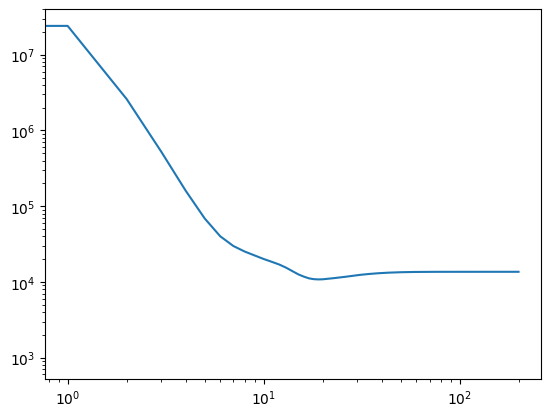

In [118]:
plt.loglog(loss)

In [119]:
S = {node: X[:,node*100:(node+1)*100]
     for node in nodes}

In [120]:
def premultiplier(Xu, Xv):
    uu = np.linalg.pinv(Xu @ Xu.T)
    uv = Xu @ Xv.T
    vv = np.linalg.pinv(Xv @ Xv.T)
    vu = Xv @ Xu.T

    return (uu, uv, vv, vu)

def chi_u(uu, uv, vv, vu):

    return ((uu @ uv - np.eye(uu.shape[0])) @ vv @ np.linalg.pinv(vu @ uu @ uv @ vv - np.eye(uu.shape[0])) @ vu - np.eye(uu.shape[0])) @ uu

def chi_v(uu, uv, vv, vu):

    return (uu @ uv - np.eye(uu.shape[0])) @ vv @ np.linalg.pinv(vu @ uu @ uv @ vv - np.eye(uu.shape[0]))

In [121]:
T = 0

H = {
    edge : {
        edge[0] : None,
        edge[1] : None
    }
for edge in combinations(nodes, 2)
}

In [122]:
for e in tqdm(combinations(nodes,2)):
    u = e[0]
    v = e[1]

    X_u = S[u]
    X_v = S[v]
    uu, uv, vv, vu = premultiplier(X_u, X_v)

    H[e][u] = chi_u(uu, uv, vv, vu)
    H[e][v] = chi_u(uu, uv, vv, vu)
    
    T += np.trace(H[e][u]) + np.trace(H[e][v])

21it [00:00, 393.29it/s]


In [123]:
T

-419404760779.4005

In [124]:
mu = T

In [125]:
H = {
    edge : {
        edge[0] : mu/T * (H[edge][edge[0]]),
        edge[1] : mu/T * (H[edge][edge[1]])
    }
for edge in combinations(nodes, 2)
}

In [126]:
all_edges = list(combinations(range(V), 2))

energies = {
    e : 0
    for e in all_edges
    }

for e in (all_edges):
    u = e[0]
    v = e[1]
    
    '''
    X_ = np.zeros_like(X)
    X_[u*d:(u+1)*d,:] = X[u*d:(u+1)*d,:]
    X_[v*d:(v+1)*d,:] = X[v*d:(v+1)*d,:]
    energies[e] = np.linalg.norm(BB @ X_)
    '''

    energies[e] = np.linalg.norm(H[e][e[0]] @ S[e[0]] - H[e][e[1]] @ S[e[1]])

In [127]:
retrieved = sorted(energies.items(), key=lambda x:x[1])[:E]

In [128]:
len(set(list(map(lambda x: x[0], retrieved))).intersection(set(edges))) / E

0.25

In [129]:
retrieved

[((4, 6), 180226.27574854647),
 ((1, 6), 944788.5608800974),
 ((4, 5), 999807.4779208448),
 ((0, 3), 1150721.4393479198),
 ((3, 6), 2395920.681194651),
 ((1, 3), 2819713.433883345),
 ((2, 6), 3112816.6594633837),
 ((1, 4), 4216210.663520044)]